+# Sea Level Rise Migration Research 


## Introduction
This project is the analytical accompaniment to a research paper for a Populaiton Mobility class within the Demography master's program at Florida State University. 

Spring Semester 2021
Submitted 4/17/2021

## Data
Data comes from the Federal Emergency Management Agency (FEMA) and the Internal Revenues Service (IRS).
FEMA provides data on designated disasters for U.S. states and territories. Data includes disaster summaries, and funding total from various recovery and mitigation porgrams operated by the agency. The IRS provides state-to-state and county-to-county migration flows developed through address changes on tax return filings. The IRS's reporting procedures changed beginning with the 2011-2012 year and stop at the 2017 - 2018 year preventing a more extended analysis. 

In [2]:
import pandas as pd 
import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import requests
import seaborn as sns
import sys
import os
import urllib.request
import json
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from patsy import dmatrices
from datetime import datetime
from sklearn import linear_model
from stargazer.stargazer import Stargazer

#
%matplotlib inline

#Adjust default map size
matplotlib.rcParams['figure.figsize'] = [16,10]

SyntaxError: invalid syntax (<ipython-input-2-0494ae09f81b>, line 3)

In [2]:
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_rows", 100)
pd.set_option('display.float_format', lambda x:'%.5f'%x)

## Load IRS Migration Data

In [3]:
#Opens migration dataframes for each year the manual way

col_names = ['org_state', 'org_county','dest_state', 
             'dest_county','StateAbbre','dest_description',
             'num_returns','num_exempts','AGI']

df1112 = pd.read_csv('./countyoutflow1112.csv',
           encoding='gbk', names=col_names,low_memory=False, skiprows=1)
df1213 = pd.read_csv('./countyoutflow1213.csv',
           encoding='gbk', names=col_names, low_memory=False, skiprows=1)
df1314 = pd.read_csv('./countyoutflow1314.csv',
           encoding='gbk', names=col_names, low_memory=False, skiprows=1)
df1415 = pd.read_csv('./countyoutflow1415.csv',
           encoding='gbk', names=col_names, low_memory=False, skiprows=1)
df1516 = pd.read_csv('./countyoutflow1516.csv',
           encoding='gbk', names=col_names, low_memory=False, skiprows=1)
df1617 = pd.read_csv('./countyoutflow1617.csv',
           encoding='gbk', names=col_names, low_memory=False, skiprows=1)
df1718 = pd.read_csv('./countyoutflow1718.csv',
           encoding='gbk', names=col_names, low_memory=False, skiprows=1)

        
df_dict = {
    1112:df1112, 1314:df1314, 1415:df1415,
    1516:df1516, 1617:df1617, 1718:df1718}


## Clean IRS Migrataion Data

Migration data is provide by the Internal Revenue Service (IRS) and is based on year-to-year changes of address as reported on individual tax returns. Migration flows are avaliable at the state-to-state and the county-to-county level and are provided as inflows and as outflows. Data reported includes the number of returns filed which approximates the number of households that moved and the number of personal exemptions which approximates the number of individuals that moved. 

In [4]:
#Takes raw IRS Migration dataset 2011-2018, and year label:
#Returns a state and county dataframe in that order
    #Adds Labels
    #Filters
def fix_mig_data(mig_df, year):   #<----Fix so year gets itself 
    
    # Add year migration years to IRS migration dataframe
    def add_mig_yr_col(mig_df, year):
        mig_df['mig_yr'] = year
        return mig_df
    working = add_mig_yr_col(mig_df, year)
    return (working)

## FEMA Disaster Declaration Summaries

Fema disaster declaration summaries are provided through the OpenFEMA data repository located at https://www.fema.gov/openfema-data-page/disaster-declarations-summaries-v2. The dataset is a summarized description of all federally delcared disasters since the first disaster declaration in 1953. Three types of declaration types are included, major disaster, emergency, and fire management assistance. (### insert bit about removing any of these if removed)  

In [5]:
#Load FEMA Disaster Declaration Summaries data from local files
dis_df = pd.read_csv('./DisasterDeclarationsSummaries.csv')

#Select dates from 2009 on given migraiton data is avaliable in a continuous form from 2011-2018. Accounts for a
# two-year lag as timing for migration data to show up in returns. 
dis_df = dis_df[(dis_df['declarationDate']>='2009-01-01T00:00:00.000Z') &
                (dis_df['declarationDate']<= '2018-01-01T00:00:00.000Z')]

#Reset index and drop old index
dis_df = dis_df.reset_index()
dis_df.drop('index', inplace=True, axis=1)

In [6]:
#Selects disasters by fiscal year
def date_selector(dis_df, year):## <<---------------------------Add function for multiple years
    #Create date selector funciton
    dis_dfselect = dis_df[dis_df['fyDeclared'] == year]
    return(dis_dfselect)
    #mini_df = mini_df[['fipsStateCode','fipsCountyCode','fyDeclared']]sd

## Merge IRS and Disaster Declarations Summaries

In [7]:
#Merge a filtered migration dataframe with a disaster dataframe that has been selected by year
def mig_dis_merge(mig_df, dis_df): 
        merged = pd.merge(mig_df, dis_df, 
                          left_on=['org_state',"org_county"],
                          right_on = ['fipsStateCode','fipsCountyCode' ], how='left')

        #merged.fillna(False, inplace=True)
       
        #After columns are used to match in the merge reformat state and county FIPS
        # codes to contain leading zeros
        merged['org_state']=merged['org_state'].apply(lambda x: '{0:0>2}'.format(x))
        merged['dest_state']=merged['dest_state'].apply(lambda x: '{0:0>2}'.format(x))
        merged['org_county']=merged['org_county'].apply(lambda x: '{0:0>3}'.format(x))
        merged['dest_county']=merged['dest_county'].apply(lambda x: '{0:0>3}'.format(x))
        
        
        return(merged)

        #Un-comment below to save to current working directory
        #Need to fix nameing convention to distinguish between summary and non summary dfs
        #save_name = "merged_data.xlsx"
        #print(save_name)
        #merged.to_excel(save_name)

## Add FEMA Funding Program Summaries to Merged Datasets

In [8]:
# Load FEMA Program Data from local file 
program_df = pd.read_csv('./FemaWebDisasterSummaries_.csv')
program_df.drop(['id','hash','lastRefresh','paLoadDate','iaLoadDate'], axis=1,inplace=True)

In [9]:
'''Merges cleaned IRS migration data with cleaned FEMA program summaries'''
def add_program_summaries(mig_df, program_df):
    #Get FEMA funding program summaries for each unique disaster number in our merged dataframe
    program_ = program_df[program_df['disasterNumber'].isin(mig_df['disasterNumber'].unique())]
    
    #Change disaster number from float to integer
    mig_df['disasterNumber']=mig_df['disasterNumber'].map(lambda x: int(x))
    program_df['disasterNumber']=program_df['disasterNumber'].map(lambda x: int(x))
    
    merger = pd.merge(mig_df, program_df, on='disasterNumber', how="left")
    return(merger)

## Add FEMA Mitigation Properties to Merged Datasets

# Mark for later
Section not part of "FEMA Funding: Do they stay or do they go?" paper but may be useful for later work

In [10]:
# prop_df = pd.read_csv("./HazardMitigationAssistanceMitigatedProperties.csv")

In [11]:
# #Change FIPS codes in df to string, split to remove decimal and trailing 0
# prop_df['stateNumberCode']= prop_df['stateNumberCode'].astype(str).apply(lambda x: x.split(".")[0]).copy()
# prop_df['countyCode']= prop_df['countyCode'].astype(str).apply(lambda x: x.split(".")[0]).copy()
# #Add leading zeros to state and county FIPS codes 
# prop_df['stateNumberCode']= prop_df['stateNumberCode'].apply(lambda x: '{0:0>2}'.format(x))
# prop_df['countyCode']= prop_df['countyCode'].apply(lambda x: '{0:0>3}'.format(x))
# #Combine FIPS codes to unique state-county identifier
# prop_df['FIPS'] = prop_df['stateNumberCode']+prop_df['countyCode']

In [12]:
# Merge FEMA Property data to big df 
#bdf = big_df.merge(prop_df,how='left', left_on=['orgFIPS','disasterNumber'],right_on=['FIPS','disasterNumber'])

## Turn cleaning code into single funciton

In [13]:
def all_together(dis_dec_sums, irs_mig, dis_programs, dis_year, mig_year):
    dis_df = date_selector(dis_dec_sums, dis_year)#<----- May be a problem here if multiple years added
    mig_df = fix_mig_data(irs_mig, mig_year)
    
    mig_merged = mig_dis_merge(mig_df, dis_df)
    
#     #Add programs
#     state_df = add_program_summaries(state_merged, dis_programs)
#     county_df = add_program_summaries(county_merged, dis_programs)
    
    return(mig_merged)  

## Put it all together 

In [14]:
#Processes and puts together migration and disaster program summaries from dataframes on
# the computer. See above for adjusting file path or building out API call where avaliable.
#Year adjustment to be used for matching disaster data with a lag.

mig1112 = all_together(dis_df, df1112, program_df, 2011,'1112')
mig1213 = all_together(dis_df, df1213, program_df, 2012,'1213')
mig1314 = all_together(dis_df, df1314, program_df, 2013,'1314')
mig1415 = all_together(dis_df, df1415, program_df, 2014,'1415')
mig1516 = all_together(dis_df, df1516, program_df, 2015,'1516')
mig1617 = all_together(dis_df, df1617, program_df, 2016,'1617')
mig1718 = all_together(dis_df, df1718, program_df, 2017,'1718')

In [15]:
#Create summary code combining State and County FIPS codes
def FIPS_cats(df):
    df['orgFIPS']= df['org_state']+df['org_county']
    df['destFIPS']= df['dest_state']+df['dest_county']

In [16]:
# List of project dataframes for passing to concat funciton
data_dfs=[mig1112,
          mig1213,
          mig1314, 
          mig1415, 
          mig1516, 
          mig1617, 
          mig1718] 

#concatenate all the df in list
big_df = pd.concat(data_dfs)

#add county state FIPS codes together to create unique identifier
FIPS_cats(big_df)

# Creates a dummy variable for the non-migrant total(1 = non-migrants)
big_df['non_mig'] = np.where(big_df['dest_description'].str.contains('Non-migrants'), 1,0)

#Creates a dummy variable for a disaster occuring (1 = disaster occured)
big_df['disasterFlag'] = np.where(big_df['disasterNumber'].isnull(), 0, 1)

#Changes instances where disasterNumber was false to 0 so that it will be grouped
big_df["disasterNumber"] = big_df['disasterNumber'].fillna(0)

#Creates dummy variable for rows that are state totals (1=state total)
big_df['stateTotal_flag']=np.where(big_df['dest_description'].str.startswith('Total'), 1,0)

In [17]:
#drop uneeded columns
big_df.drop(['hash','lastRefresh','id'],inplace=True, axis=1)


In [18]:
#Re-order to move FIPS identifiers up front
big_df = big_df[['orgFIPS','org_state','org_county','destFIPS',
                 'dest_state','dest_county','StateAbbre','dest_description',
                 'num_returns','num_exempts','AGI','mig_yr','femaDeclarationString',
                 'disasterNumber','state','declarationType','declarationDate','fyDeclared',
                 'incidentType','declarationTitle','ihProgramDeclared','iaProgramDeclared',
                 'paProgramDeclared','hmProgramDeclared', 'incidentBeginDate', 'incidentEndDate',
                 'disasterCloseoutDate', 'fipsStateCode', 'fipsCountyCode', 'placeCode',
                 'designatedArea', 'declarationRequestNumber','non_mig','disasterFlag', 'stateTotal_flag']].copy()

In [19]:
#Filter dataset for only migrant data in disaster counties
#big_df[(big_df['non_mig']==0)& (big_df['disasterFlag']==1)]

## Create population totals
This section pulls migrants and non migrants out of the big_df. We reset the index and made a new identifier investigating duplication issues. We then merged this into one dataframe for easier operations. A new column that added together the migrants and non migrants together was then put together and matched back to the big_df to add a total populaiton column.

In [20]:
non_migs= big_df[(big_df['stateTotal_flag']==0)&
                 (big_df['non_mig']==1)][['orgFIPS', 'num_exempts',
                                          "non_mig",'dest_description','mig_yr']]
non_migs.reset_index(inplace=True, drop=True)

In [21]:
county_migs= big_df[(big_df['stateTotal_flag']==0)&
                    (big_df['non_mig']==0)&
                    (big_df['destFIPS']=="96000")][['orgFIPS', 'num_exempts',
                                                    "non_mig",'dest_description','mig_yr']]
county_migs.reset_index(inplace=True, drop=True)

In [22]:
#
county_migs['fipsyr']=county_migs['orgFIPS'] + county_migs['mig_yr']
non_migs['fipsyr']=non_migs['orgFIPS'] + non_migs['mig_yr']
#
countypop = county_migs.merge(non_migs, on=['fipsyr'], how='left')
countypop = countypop[~countypop.duplicated()]

In [23]:
countypop['totalPop'] = countypop['num_exempts_x']+countypop['num_exempts_y']

In [24]:
countypop = countypop[['orgFIPS_x','mig_yr_x','totalPop']].copy()

In [25]:
countypop.to_excel('./county_totals.xlsx')

In [26]:
big_df=big_df.merge(countypop,left_on=['orgFIPS','mig_yr'], right_on=['orgFIPS_x','mig_yr_x'],how='left')

In [27]:
big_df[(big_df['stateTotal_flag']==0)&
             (big_df['non_mig']==0)&
             (big_df['destFIPS']=="96000")].head()

,orgFIPS,org_state,org_county,destFIPS,dest_state,dest_county,StateAbbre,dest_description,num_returns,num_exempts,...,fipsCountyCode,placeCode,designatedArea,declarationRequestNumber,non_mig,disasterFlag,stateTotal_flag,orgFIPS_x,mig_yr_x,totalPop
5,01001,01,001,96000,96,000,AL,Autauga County Total Migration-US and Foreign,2125,4776,...,1.00000,99001.00000,Autauga (County),11081.00000,0,1,0,01001,1112,46533.00000
6,01001,01,001,96000,96,000,AL,Autauga County Total Migration-US and Foreign,2125,4776,...,1.00000,99001.00000,Autauga (County),11079.00000,0,1,0,01001,1112,46533.00000
85,01003,01,003,96000,96,000,AL,Baldwin County Total Migration-US and Foreign,4327,8728,...,3.00000,99003.00000,Baldwin (County),11081.00000,0,1,0,01003,1112,152986.00000
86,01003,01,003,96000,96,000,AL,Baldwin County Total Migration-US and Foreign,4327,8728,...,3.00000,99003.00000,Baldwin (County),11079.00000,0,1,0,01003,1112,152986.00000
247,01005,01,005,96000,96,000,AL,Barbour County Total Migration-US and Foreign,771,1599,...,5.00000,99005.00000,Barbour (County),11081.00000,0,1,0,01005,1112,19571.00000


In [28]:
#big_df.to_excel("/Users/jt/Desktop/Spring 2021/Population Mobility/Research Paper/JNB_Pop_Mobility/Data/Processed/big_df.xlsx")

## Filter dataset into usable pieces

In [29]:
#Filters big_df removing state totals and non-migrant totals to leave only county totals
#Groups by disaster number and origin identifier
gp_df=big_df[(big_df['stateTotal_flag']==0)&
             (big_df['non_mig']==0)&
             (big_df['destFIPS']=="96000")&
            (big_df['num_exempts']!=-1)].groupby(['disasterNumber']).sum()
#Changes the disaster flag back to ones and zeros
gp_df['disasterFlag'] = np.where(gp_df['disasterFlag']>0,1,0)

In [30]:
#Reset grouped df index and merge to program data
progs = add_program_summaries(gp_df.reset_index(),program_df)

In [31]:
#Create columns with totals for obligated and obligated and approved dollars
progs['totalObligated']= progs.loc[:,['totalObligatedAmountPa', 
            'totalObligatedAmountCatAb','totalObligatedAmountCatC2g',
            'totalObligatedAmountHmgp']].sum(axis=1)
progs['totalObligated_Approved']= progs.loc[:,['totalAmountIhpApproved','totalAmountHaApproved',
            'totalAmountOnaApproved','totalObligatedAmountPa', 
            'totalObligatedAmountCatAb','totalObligatedAmountCatC2g',
            'totalObligatedAmountHmgp']].sum(axis=1)

# Analysis

### Beginning exploratory data analysis

In [32]:
#progs.info()

In [33]:
#progs.describe()

#### Note:
Un-comment code below to find the disaster number associated with hurricane Sandy. Because of where this hit there was a lot of FEMA money spent here. Something to be aware of. 

In [34]:
# big_df[big_df['disasterNumber']==4085]
#

<AxesSubplot:xlabel='totalObligated', ylabel='num_exempts'>

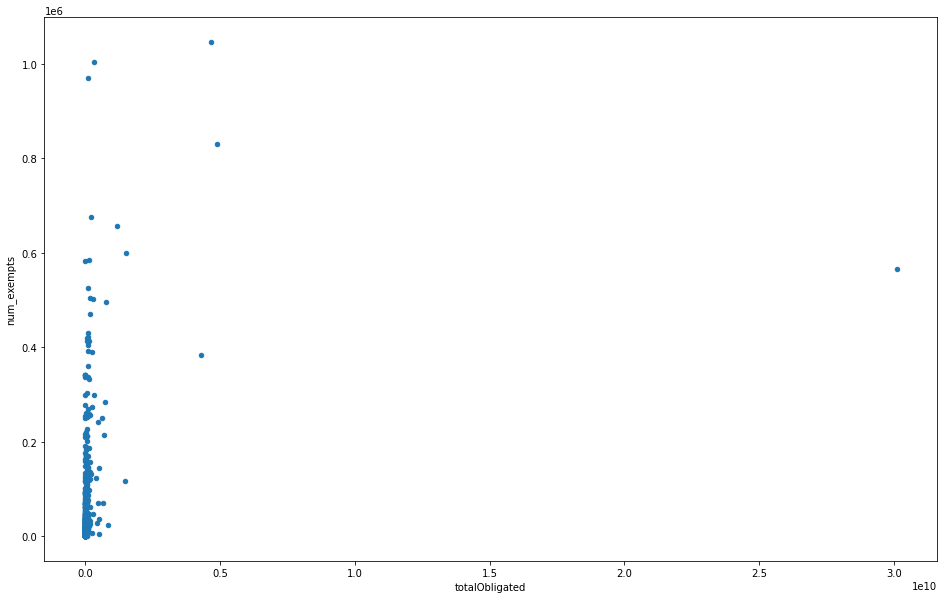

In [35]:
progs[(progs['totalObligated']>0)].plot.scatter(x='totalObligated',y='num_exempts')

In [36]:
progs['totOb_log']= np.log(progs['totalObligated']+1)
progs['totObAp_log']= np.log(progs['totalObligated_Approved']+1)
progs['numexempt_log']= np.log(progs['num_exempts']+1)

In [37]:
progs.to_excel('./progs_df.xlsx')

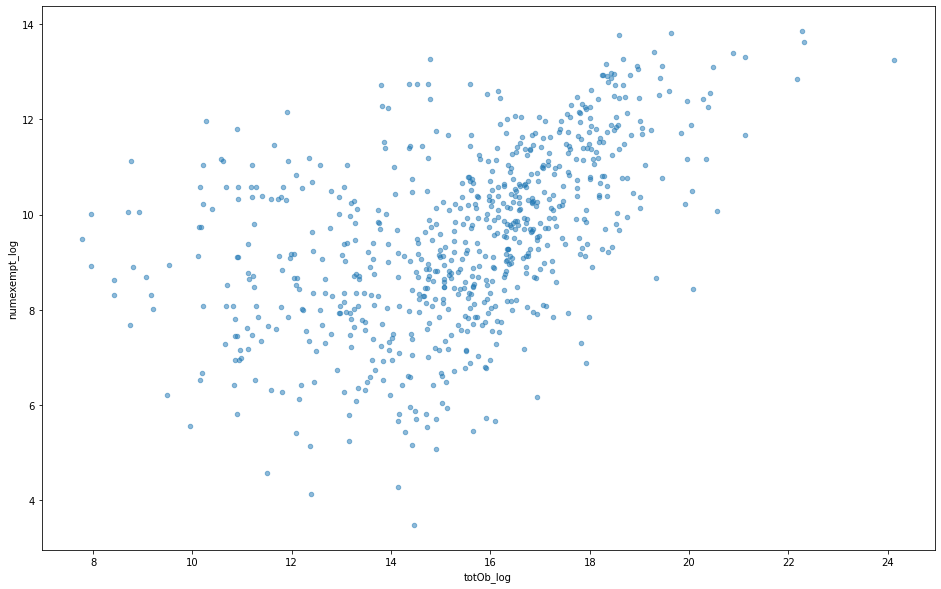

In [38]:
progs[progs['totalObligated']>0].plot.scatter('totOb_log','numexempt_log',alpha=.5);

In [39]:
# Number of instance that are surpressed in the IRS data (# surpressed = 174)
#big_df[(big_df["destFIPS"]=="96000")&(big_df['stateTotal_flag']==0)&(big_df['num_exempts']==-1)]

## Big df regression analysis

In [40]:
#big_df['numexempt_log']= np.log(big_df['num_exempts']+2)
big_df.columns

Index(['orgFIPS', 'org_state', 'org_county', 'destFIPS', 'dest_state',
       'dest_county', 'StateAbbre', 'dest_description', 'num_returns',
       'num_exempts', 'AGI', 'mig_yr', 'femaDeclarationString',
       'disasterNumber', 'state', 'declarationType', 'declarationDate',
       'fyDeclared', 'incidentType', 'declarationTitle', 'ihProgramDeclared',
       'iaProgramDeclared', 'paProgramDeclared', 'hmProgramDeclared',
       'incidentBeginDate', 'incidentEndDate', 'disasterCloseoutDate',
       'fipsStateCode', 'fipsCountyCode', 'placeCode', 'designatedArea',
       'declarationRequestNumber', 'non_mig', 'disasterFlag',
       'stateTotal_flag', 'orgFIPS_x', 'mig_yr_x', 'totalPop'],
      dtype='object')

In [41]:
# filter removes 
y1,X1 = dmatrices("num_exempts ~ disasterFlag  ",
                data=big_df[(big_df["destFIPS"]=="96000")&
                            (big_df['stateTotal_flag']==0)&
                            (big_df['num_exempts']!=-1)],
                return_type ='dataframe')
model1 = sm.OLS(y1, X1)
res1 = model1.fit()
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            num_exempts   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     73.88
Date:                Thu, 15 Apr 2021   Prob (F-statistic):           8.80e-18
Time:                        23:22:23   Log-Likelihood:            -2.6699e+05
No. Observations:               24310   AIC:                         5.340e+05
Df Residuals:                   24308   BIC:                         5.340e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     4577.2055    113.607     40.290      0.000    4354.528    4799.883
disasterFlag  1642.1332    191.051      8.595      0.000    1267.661    2016.606
==============================================================================
Omnibus:                    35036.289   Durbin-Watson:                   1.404
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         14934305.484
Skew:                           8.623   Prob(JB):                         0.00
Kurtosis:                     123.193   Cond. No.                         2.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
# filter removes 
y1,X1 = dmatrices("num_exempts ~ disasterFlag ",
                data=big_df[(big_df["destFIPS"]=="96000")&
                            (big_df['stateTotal_flag']==0)&
                            (big_df['num_exempts']!=-1)],
                return_type ='dataframe')
model1 = sm.OLS(y1, X1)
res1 = model1.fit()

# 
y2,X2 = dmatrices("num_exempts ~ disasterFlag + AGI  ",
                data=big_df[(big_df["destFIPS"]=="96000")&
                            (big_df['stateTotal_flag']==0)&
                            (big_df['num_exempts']!=-1)],
                return_type ='dataframe')
model2 = sm.OLS(y2, X2)
res2 = model2.fit()

#
y3,X3 = dmatrices("num_exempts ~ disasterFlag + totalPop ",
                data=big_df[(big_df["destFIPS"]=="96000")&
                            (big_df['stateTotal_flag']==0)&
                            (big_df['num_exempts']!=-1)],
                return_type ='dataframe')
model3 = sm.OLS(y3, X3)
res3 = model3.fit()

#
y4,X4 = dmatrices("num_exempts ~ disasterFlag + AGI + totalPop ",
                data=big_df[(big_df["destFIPS"]=="96000")&
                            (big_df['stateTotal_flag']==0)&
                            (big_df['num_exempts']!=-1)],
                return_type ='dataframe')
model4 = sm.OLS(y4, X4)
res4 = model4.fit()

stargazer=Stargazer([res1,res2,res3,res4])
stargazer.title('Disasters, Funding and Migration:Disaster/Migration Lin-Lin ')
stargazer.covariate_order(['disasterFlag','AGI','totalPop'])
stargazer.custom_columns(labels=['Model 1','Model 2', 'Model 3','Model 4'],separators=[1,1,1,1])
stargazer

In [43]:
# filter removes 
y1,X1 = dmatrices("np.log(num_exempts) ~ disasterFlag ",
                data=big_df[(big_df["destFIPS"]=="96000")&
                            (big_df['stateTotal_flag']==0)&
                            (big_df['num_exempts']!=-1)],
                return_type ='dataframe')
model1 = sm.OLS(y1, X1)
res1 = model1.fit()

# 
y2,X2 = dmatrices("np.log(num_exempts) ~ disasterFlag + AGI  ",
                data=big_df[(big_df["destFIPS"]=="96000")&
                            (big_df['stateTotal_flag']==0)&
                            (big_df['num_exempts']!=-1)],
                return_type ='dataframe')
model2 = sm.OLS(y2, X2)
res2 = model2.fit()

#
y3,X3 = dmatrices("np.log(num_exempts) ~ disasterFlag + totalPop ",
                data=big_df[(big_df["destFIPS"]=="96000")&
                            (big_df['stateTotal_flag']==0)&
                            (big_df['num_exempts']!=-1)],
                return_type ='dataframe')
model3 = sm.OLS(y3, X3)
res3 = model3.fit()

#
y4,X4 = dmatrices("np.log(num_exempts) ~ disasterFlag + AGI + totalPop ",
                data=big_df[(big_df["destFIPS"]=="96000")&
                            (big_df['stateTotal_flag']==0)&
                            (big_df['num_exempts']!=-1)],
                return_type ='dataframe')
model4 = sm.OLS(y4, X4)
res4 = model4.fit()

stargazer=Stargazer([res1,res2,res3,res4])
stargazer.title('Disasters, Funding, and Migration:Disaster/Migraiton Log-Lin')
stargazer.covariate_order(['disasterFlag','AGI','totalPop'])
stargazer.custom_columns(labels=['Model 1','Model 2', 'Model 3','Model 4'],separators=[1,1,1,1])
stargazer

## Progs_df regression analysis

In [44]:
#progs[progs['disasterNumber']>0]

In [45]:
# y1,X1 = dmatrices("num_exempts ~  totalObligated",
#                 data=progs[progs['disasterNumber']>0], return_type="dataframe")
# model1 = sm.OLS(y1, X1)
# res1 = model1.fit()
# #res1.summary()

# y2,X2 = dmatrices("num_exempts ~  totalObligated + totalPop",
#                 data=progs[progs['disasterNumber']>0], return_type="dataframe")
# model2 = sm.OLS(y2, X2)
# res2 = model2.fit()
# #res2.summary()

# y3,X3 = dmatrices("num_exempts ~  totalObligated+ AGI",
#                 data=progs[progs['disasterNumber']>0], return_type="dataframe")
# model3 = sm.OLS(y3, X3)
# res3 = model3.fit()
# #res3.summary()

# y4,X4 = dmatrices("num_exempts ~  totalObligated + totalPop + AGI",
#                 data=progs[progs['disasterNumber']>0], return_type="dataframe")
# model4 = sm.OLS(y4, X4)
# res4 = model4.fit()
# #res4.summary()

# stargazer=Stargazer([res1,res2,res3,res4])
# stargazer.significant_digits(5)
# stargazer.title('Disasters, Funding, and Migration:Program Summary Lin-Lin')
# stargazer.covariate_order(['totalObligated','AGI','totalPop'])
# stargazer.custom_columns(labels=['Model 1','Model 2', 'Model 3','Model 4'],
#                          separators=[1,1,1,1])
# stargazer

##  Lin-Lin Programs

In [46]:
y1,X1 = dmatrices("num_exempts ~  totalObligated_Approved",
                data=progs[progs['disasterNumber']>0], return_type="dataframe")
model1 = sm.OLS(y1, X1)
res1 = model1.fit()
#res1.summary()

y2,X2 = dmatrices("num_exempts ~  totalObligated_Approved + totalPop",
                data=progs[progs['disasterNumber']>0], return_type="dataframe")
model2 = sm.OLS(y2, X2)
res2 = model2.fit()
#res2.summary()

y3,X3 = dmatrices("num_exempts ~  totalObligated_Approved+ AGI",
                data=progs[progs['disasterNumber']>0], return_type="dataframe")
model3 = sm.OLS(y3, X3)
res3 = model3.fit()
#res3.summary()

y4,X4 = dmatrices("num_exempts ~  totalObligated_Approved + totalPop + AGI",
                data=progs[progs['disasterNumber']>0], return_type="dataframe")
model4 = sm.OLS(y4, X4)
res4 = model4.fit()
#res4.summary()

#
y5,X5 = dmatrices("num_exempts ~  totalObligated_Approved + totalPop + AGI+ disasterFlag",
                data=progs[progs['disasterNumber']>0], return_type="dataframe")
model5 = sm.OLS(y5, X5)
res5 = model5.fit()

stargazer=Stargazer([res1,res2,res3,res4,res5])
stargazer.significant_digits(5)
stargazer.title('Disasters, Funding, and Migration:Program Summary Lin-Lin')
stargazer.covariate_order(['totalObligated_Approved','AGI','totalPop','disasterFlag'])
stargazer.custom_columns(labels=['Model 1','Model 2', 'Model 3','Model 4', 'Model 5'],
                         separators=[1,1,1,1,1])

stargazer

## Log-Lin Programs

In [47]:
y1,X1 = dmatrices("np.log(num_exempts) ~  totalObligated_Approved",
                data=progs[progs['disasterNumber']>0], return_type="dataframe")
model1 = sm.OLS(y1, X1)
res1 = model1.fit()
#res1.summary()

y2,X2 = dmatrices("np.log(num_exempts) ~  totalObligated_Approved + totalPop",
                data=progs[progs['disasterNumber']>0], return_type="dataframe")
model2 = sm.OLS(y2, X2)
res2 = model2.fit()
#res2.summary()

y3,X3 = dmatrices("np.log(num_exempts) ~  totalObligated_Approved+ AGI",
                data=progs[progs['disasterNumber']>0], return_type="dataframe")
model3 = sm.OLS(y3, X3)
res3 = model3.fit()
#res3.summary()

y4,X4 = dmatrices("np.log(num_exempts) ~  totalObligated_Approved + totalPop + AGI",
                data=progs[progs['disasterNumber']>0], return_type="dataframe")
model4 = sm.OLS(y4, X4)
res4 = model4.fit()
#res4.summary()

#
y5,X5 = dmatrices("np.log(num_exempts) ~  totalObligated_Approved + totalPop + AGI+ disasterFlag",
                data=progs[progs['disasterNumber']>0], return_type="dataframe")
model5 = sm.OLS(y5, X5)
res5 = model5.fit()

stargazer=Stargazer([res1,res2,res3,res4,res5])
stargazer.significant_digits(5)
stargazer.title('Disasters, Funding, and Migration:Program Summary Log-Lin')
stargazer.covariate_order(['totalObligated_Approved','AGI','totalPop','disasterFlag'])
stargazer.custom_columns(labels=['Model 1','Model 2', 'Model 3','Model 4','Model 5'],
                         separators=[1,1,1,1,1])
stargazer

In [48]:
y1,X1 = dmatrices("num_exempts ~ totObAp_log",
                data=progs[progs['disasterNumber']>0], return_type="dataframe")
model1 = sm.OLS(y1, X1)
res1 = model1.fit()
#res1.summary()

y2,X2 = dmatrices("num_exempts ~  totObAp_log + totalPop",
                data=progs[progs['disasterNumber']>0], return_type="dataframe")
model2 = sm.OLS(y2, X2)
res2 = model2.fit()
#res2.summary()

y3,X3 = dmatrices("num_exempts ~ totObAp_log + AGI",
                data=progs[progs['disasterNumber']>0], return_type="dataframe")
model3 = sm.OLS(y3, X3)
res3 = model3.fit()
#res3.summary()

y4,X4 = dmatrices("num_exempts ~  totObAp_log + totalPop + AGI",
                data=progs[progs['disasterNumber']>0], return_type="dataframe")
model4 = sm.OLS(y4, X4)
res4 = model4.fit()
#res4.summary()

#
y5,X5 = dmatrices("num_exempts ~  totObAp_log + totalPop + AGI+ disasterFlag",
                data=progs[progs['disasterNumber']>0], return_type="dataframe")
model5 = sm.OLS(y5, X5)
res5 = model5.fit()

stargazer=Stargazer([res1,res2,res3,res4,res5])
stargazer.significant_digits(5)
stargazer.title('Disasters, Funding, and Migration:Program Summary Lin-Log')
stargazer.covariate_order(['totObAp_log','AGI','totalPop','disasterFlag'])
stargazer.custom_columns(labels=['Model 1','Model 2', 'Model 3','Model 4','Model 5'],
                         separators=[1,1,1,1,1])
stargazer

In [49]:
y1,X1 = dmatrices("np.log(num_exempts) ~ totObAp_log",
                data=progs[progs['disasterNumber']>0], return_type="dataframe")
model1 = sm.OLS(y1, X1)
res1 = model1.fit()
#res1.summary()

y2,X2 = dmatrices("np.log(num_exempts) ~  totObAp_log + totalPop",
                data=progs[progs['disasterNumber']>0], return_type="dataframe")
model2 = sm.OLS(y2, X2)
res2 = model2.fit()
#res2.summary()

y3,X3 = dmatrices("np.log(num_exempts) ~ totObAp_log + AGI",
                data=progs[progs['disasterNumber']>0], return_type="dataframe")
model3 = sm.OLS(y3, X3)
res3 = model3.fit()
#res3.summary()

y4,X4 = dmatrices("np.log(num_exempts) ~  totObAp_log + totalPop + AGI",
                data=progs[progs['disasterNumber']>0], return_type="dataframe")
model4 = sm.OLS(y4, X4)
res4 = model4.fit()
#res4.summary()

#
y5,X5 = dmatrices("np.log(num_exempts) ~  totObAp_log + totalPop + AGI+ disasterFlag",
                data=progs[progs['disasterNumber']>0], return_type="dataframe")
model5 = sm.OLS(y5, X5)
res5 = model5.fit()

stargazer=Stargazer([res1,res2,res3,res4,res5])
stargazer.significant_digits(5)
stargazer.title('Disasters, Funding, and Migration:Program Summary Log-Log')
stargazer.covariate_order(['totObAp_log','AGI','totalPop','disasterFlag'])
stargazer.custom_columns(labels=['Model 1','Model 2', 'Model 3','Model 4','Model 5'],
                         separators=[1,1,1,1,1])
stargazer

## Progs_df regression analysis

In [50]:
#progs[progs['disasterNumber']>0]

In [51]:
# y1,X1 = dmatrices("num_exempts ~  totalObligated",
#                 data=progs[progs['disasterNumber']>0], return_type="dataframe")
# model1 = sm.OLS(y1, X1)
# res1 = model1.fit()
# #res1.summary()

# y2,X2 = dmatrices("num_exempts ~  totalObligated + totalPop",
#                 data=progs[progs['disasterNumber']>0], return_type="dataframe")
# model2 = sm.OLS(y2, X2)
# res2 = model2.fit()
# #res2.summary()

# y3,X3 = dmatrices("num_exempts ~  totalObligated+ AGI",
#                 data=progs[progs['disasterNumber']>0], return_type="dataframe")
# model3 = sm.OLS(y3, X3)
# res3 = model3.fit()
# #res3.summary()

# y4,X4 = dmatrices("num_exempts ~  totalObligated + totalPop + AGI",
#                 data=progs[progs['disasterNumber']>0], return_type="dataframe")
# model4 = sm.OLS(y4, X4)
# res4 = model4.fit()
# #res4.summary()

# stargazer=Stargazer([res1,res2,res3,res4])
# stargazer.significant_digits(5)
# stargazer.title('Disasters, Funding, and Migration:Program Summary Lin-Lin')
# stargazer.covariate_order(['totalObligated','AGI','totalPop'])
# stargazer.custom_columns(labels=['Model 1','Model 2', 'Model 3','Model 4'],
#                          separators=[1,1,1,1])
# stargazer

##  Lin-Lin Programs

In [52]:
y1,X1 = dmatrices("num_exempts ~  totalObligated_Approved",
                data=progs[progs['disasterNumber']>0], return_type="dataframe")
model1 = sm.OLS(y1, X1)
res1 = model1.fit()
#res1.summary()

y2,X2 = dmatrices("num_exempts ~  totalObligated_Approved + totalPop",
                data=progs[progs['disasterNumber']>0], return_type="dataframe")
model2 = sm.OLS(y2, X2)
res2 = model2.fit()
#res2.summary()

y3,X3 = dmatrices("num_exempts ~  totalObligated_Approved+ AGI",
                data=progs[progs['disasterNumber']>0], return_type="dataframe")
model3 = sm.OLS(y3, X3)
res3 = model3.fit()
#res3.summary()

y4,X4 = dmatrices("num_exempts ~  totalObligated_Approved + totalPop + AGI",
                data=progs[progs['disasterNumber']>0], return_type="dataframe")
model4 = sm.OLS(y4, X4)
res4 = model4.fit()
#res4.summary()

#
y5,X5 = dmatrices("num_exempts ~  totalObligated_Approved + totalPop + AGI+ disasterFlag",
                data=progs[progs['disasterNumber']>0], return_type="dataframe")
model5 = sm.OLS(y5, X5)
res5 = model5.fit()

stargazer=Stargazer([res1,res2,res3,res4,res5])
stargazer.significant_digits(5)
stargazer.title('Disasters, Funding, and Migration:Program Summary Lin-Lin')
stargazer.covariate_order(['totalObligated_Approved','AGI','totalPop','disasterFlag'])
stargazer.custom_columns(labels=['Model 1','Model 2', 'Model 3','Model 4', 'Model 5'],
                         separators=[1,1,1,1,1])

stargazer

## Log-Lin Programs

In [53]:
y1,X1 = dmatrices("np.log(num_exempts) ~  totalObligated_Approved",
                data=progs[progs['disasterNumber']>0], return_type="dataframe")
model1 = sm.OLS(y1, X1)
res1 = model1.fit()
#res1.summary()

y2,X2 = dmatrices("np.log(num_exempts) ~  totalObligated_Approved + totalPop",
                data=progs[progs['disasterNumber']>0], return_type="dataframe")
model2 = sm.OLS(y2, X2)
res2 = model2.fit()
#res2.summary()

y3,X3 = dmatrices("np.log(num_exempts) ~  totalObligated_Approved+ AGI",
                data=progs[progs['disasterNumber']>0], return_type="dataframe")
model3 = sm.OLS(y3, X3)
res3 = model3.fit()
#res3.summary()

y4,X4 = dmatrices("np.log(num_exempts) ~  totalObligated_Approved + totalPop + AGI",
                data=progs[progs['disasterNumber']>0], return_type="dataframe")
model4 = sm.OLS(y4, X4)
res4 = model4.fit()
#res4.summary()

#
y5,X5 = dmatrices("np.log(num_exempts) ~  totalObligated_Approved + totalPop + AGI+ disasterFlag",
                data=progs[progs['disasterNumber']>0], return_type="dataframe")
model5 = sm.OLS(y5, X5)
res5 = model5.fit()

stargazer=Stargazer([res1,res2,res3,res4,res5])
stargazer.significant_digits(5)
stargazer.title('Disasters, Funding, and Migration:Program Summary Log-Lin')
stargazer.covariate_order(['totalObligated_Approved','AGI','totalPop','disasterFlag'])
stargazer.custom_columns(labels=['Model 1','Model 2', 'Model 3','Model 4','Model 5'],
                         separators=[1,1,1,1,1])
stargazer

In [54]:
y1,X1 = dmatrices("num_exempts ~ totObAp_log",
                data=progs[progs['disasterNumber']>0], return_type="dataframe")
model1 = sm.OLS(y1, X1)
res1 = model1.fit()
#res1.summary()

y2,X2 = dmatrices("num_exempts ~  totObAp_log + totalPop",
                data=progs[progs['disasterNumber']>0], return_type="dataframe")
model2 = sm.OLS(y2, X2)
res2 = model2.fit()
#res2.summary()

y3,X3 = dmatrices("num_exempts ~ totObAp_log + AGI",
                data=progs[progs['disasterNumber']>0], return_type="dataframe")
model3 = sm.OLS(y3, X3)
res3 = model3.fit()
#res3.summary()

y4,X4 = dmatrices("num_exempts ~  totObAp_log + totalPop + AGI",
                data=progs[progs['disasterNumber']>0], return_type="dataframe")
model4 = sm.OLS(y4, X4)
res4 = model4.fit()
#res4.summary()

#
y5,X5 = dmatrices("num_exempts ~  totObAp_log + totalPop + AGI+ disasterFlag",
                data=progs[progs['disasterNumber']>0], return_type="dataframe")
model5 = sm.OLS(y5, X5)
res5 = model5.fit()

stargazer=Stargazer([res1,res2,res3,res4,res5])
stargazer.significant_digits(5)
stargazer.title('Disasters, Funding, and Migration:Program Summary Lin-Log')
stargazer.covariate_order(['totObAp_log','AGI','totalPop','disasterFlag'])
stargazer.custom_columns(labels=['Model 1','Model 2', 'Model 3','Model 4','Model 5'],
                         separators=[1,1,1,1,1])
stargazer

In [55]:
y1,X1 = dmatrices("np.log(num_exempts) ~ totObAp_log",
                data=progs[progs['disasterNumber']>0], return_type="dataframe")
model1 = sm.OLS(y1, X1)
res1 = model1.fit()
#res1.summary()

y2,X2 = dmatrices("np.log(num_exempts) ~  totObAp_log + totalPop",
                data=progs[progs['disasterNumber']>0], return_type="dataframe")
model2 = sm.OLS(y2, X2)
res2 = model2.fit()
#res2.summary()

y3,X3 = dmatrices("np.log(num_exempts) ~ totObAp_log + AGI",
                data=progs[progs['disasterNumber']>0], return_type="dataframe")
model3 = sm.OLS(y3, X3)
res3 = model3.fit()
#res3.summary()

y4,X4 = dmatrices("np.log(num_exempts) ~  totObAp_log + totalPop + AGI",
                data=progs[progs['disasterNumber']>0], return_type="dataframe")
model4 = sm.OLS(y4, X4)
res4 = model4.fit()
#res4.summary()

#
y5,X5 = dmatrices("np.log(num_exempts) ~  totObAp_log + totalPop + AGI+ disasterFlag",
                data=progs[progs['disasterNumber']>0], return_type="dataframe")
model5 = sm.OLS(y5, X5)
res5 = model5.fit()

stargazer=Stargazer([res1,res2,res3,res4,res5])
stargazer.significant_digits(5)
stargazer.title('Disasters, Funding, and Migration:Program Summary Log-Log')
stargazer.covariate_order(['totObAp_log','AGI','totalPop','disasterFlag'])
stargazer.custom_columns(labels=['Model 1','Model 2', 'Model 3','Model 4','Model 5'],
                         separators=[1,1,1,1,1])
stargazer